## Dynamics Learning and Localization (DLL) with 2 Lorenz systems 


In [49]:
import numpy as np
import pysindy as ps
import scipy as sp

from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

from IPython.display import Image

In [50]:
differentiation_method = ps.FiniteDifference(order=2)

optimizer = ps.STLSQ(threshold=0.01)
lasso_optimizer = Lasso(alpha=0.001, max_iter=2000, fit_intercept=False)
sr3_optimizer = ps.SR3(threshold=0.1, nu=1)

poly_library = ps.PolynomialLibrary()
fourier_library = ps.FourierLibrary()
identity_library = ps.IdentityLibrary()
combined_library =  poly_library + identity_library + fourier_library

DLL is applied here following the derivation found in https://www.overleaf.com/project/5e5193431d431400019489a1 using the optimization functions...

## Initialization and trajectories

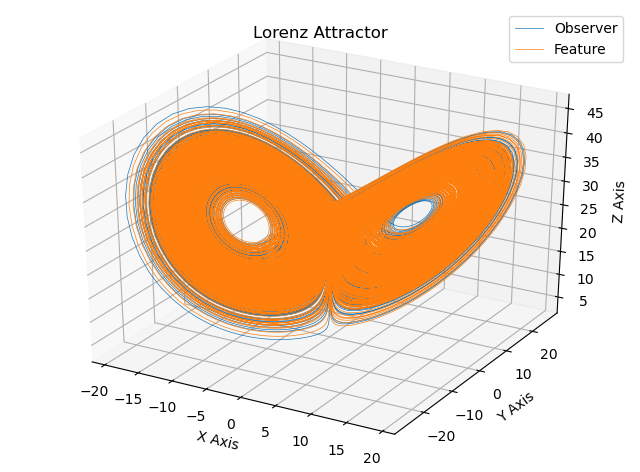

In [51]:
dt = .01 #integtration time step
tf = 500
t = np.arange(0, tf, dt) #integration length

sigma = 10
rho = 28
beta = 8/3
x0 = [0, 1, 20]
y0 = [10, 10, 20]
def lorenz(x, t, sigma, rho, beta):
    '''
    Given: 
        t: time
        x: states
        beta: parameters
    Return:
        dx: derivatives
    '''
    dx = [sigma*(x[1] - x[0]),
          x[0]*(rho - x[2]) - x[1],
          x[0]*x[1] - beta*x[2]]
                
    return dx

x = odeint(lorenz, x0, t, args = (sigma, rho, beta))
y = odeint(lorenz, y0, t, args = (sigma, rho, beta))

# Plot
fig = plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')

ax.plot(x[:,0], x[:,1], x[:,2], lw=0.5, label='Observer')
ax.plot(y[:,0], y[:,1], y[:,2], lw=0.5, label='Feature')

ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
ax.legend()

plt.show()

Text(0.5, 0.92, 'Lorenz Attractor')

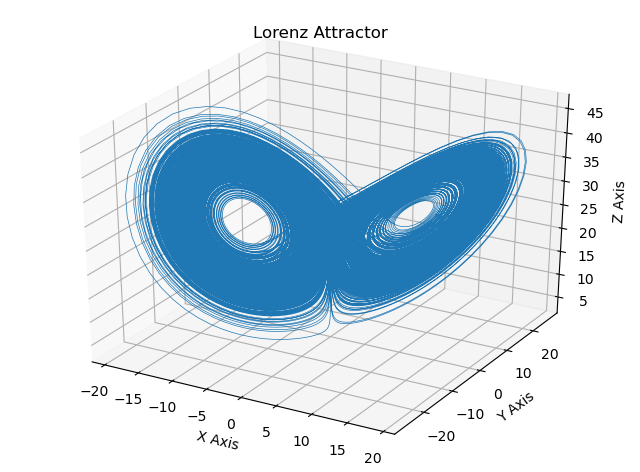

In [52]:
fig = plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')

ax.plot(x[:,0], x[:,1], x[:,2], lw=0.5, label='Observer')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

### Sytem Dynamics

<ipython-input-53-059307be08ad>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
<ipython-input-53-059307be08ad>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


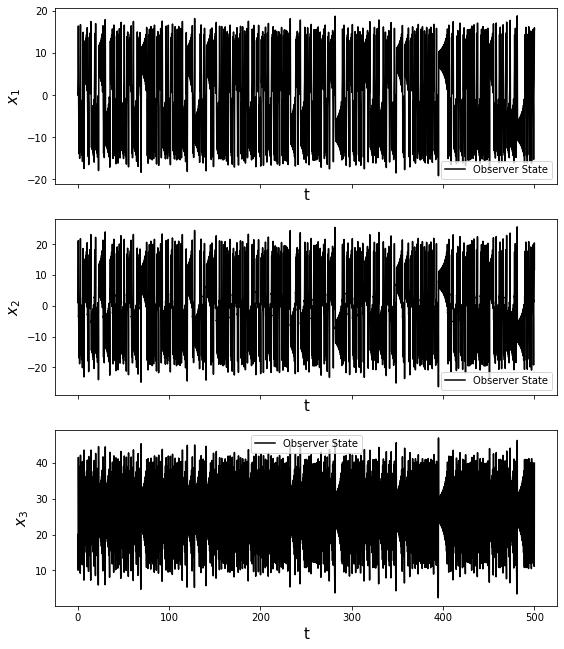

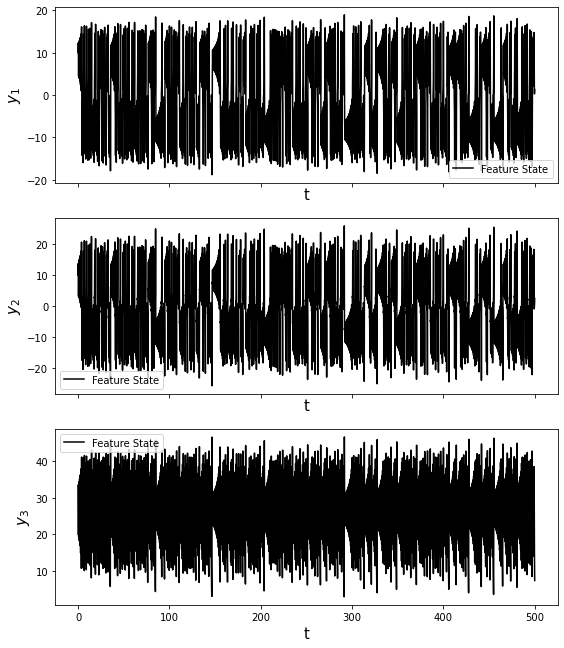

In [53]:
fig1, axs = plt.subplots(x.shape[1], 1, sharex=True, figsize=(9, 11))
for i in range(x.shape[1]):
    axs[i].plot(t, x[:, i], 'k', label='Observer State')
    axs[i].legend()
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$x_{}$'.format(i+1), fontsize = 15)
fig1.show()

fig2, axs = plt.subplots(y.shape[1], 1, sharex=True, figsize=(9, 11))
for i in range(y.shape[1]):
    axs[i].plot(t, y[:, i], 'k', label='Feature State')
    axs[i].legend()
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$y_{}$'.format(i+1), fontsize = 15)
fig2.show()

## Sindy Test

In [54]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=poly_library,
    optimizer=optimizer, feature_names=["x", "y", "z"])
model.fit(x,t=dt)
model.print() 
model.score(x,t=dt)

x' = -9.978 x + 9.978 y
y' = 27.800 x + -0.961 y + -0.994 x z
z' = -2.659 z + 0.997 x y


0.9999903441385202

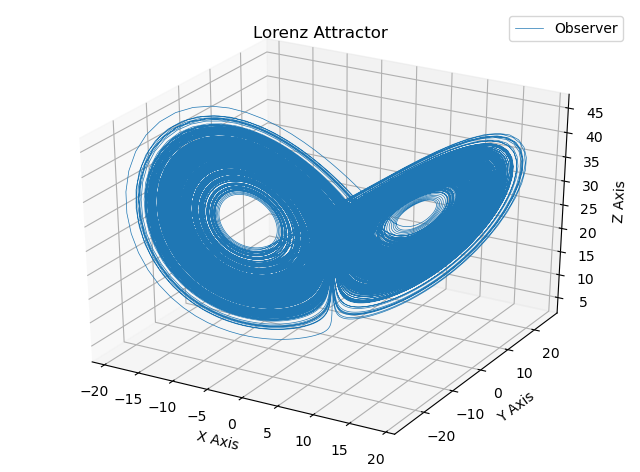

In [55]:
x_learned = model.simulate(x0, t)

# Plot Learned Dyanamical system
fig = plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')

ax.plot(x_learned[:,0], x_learned[:,1], x_learned[:,2], lw=0.5, label='Observer')

ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
ax.legend()

plt.show()

## Simulated Sensors

### Noisy relative position measurement

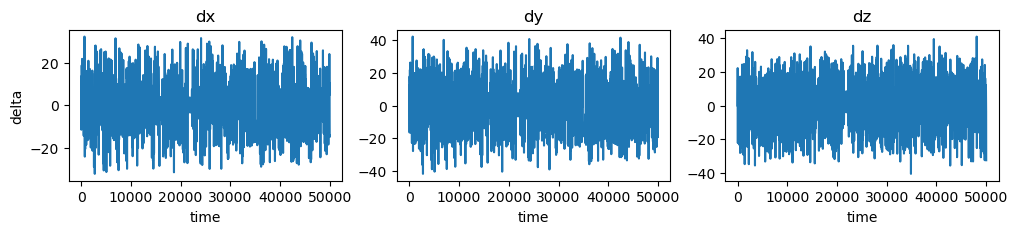

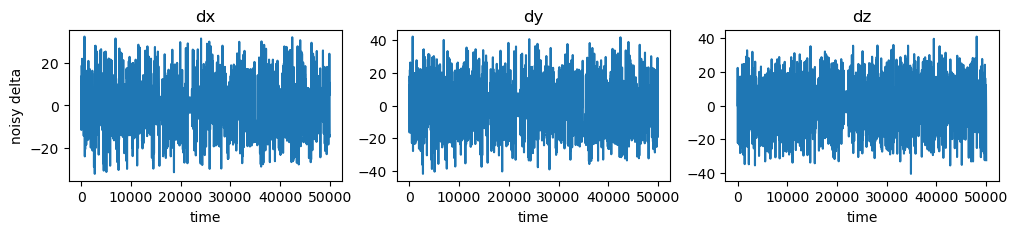

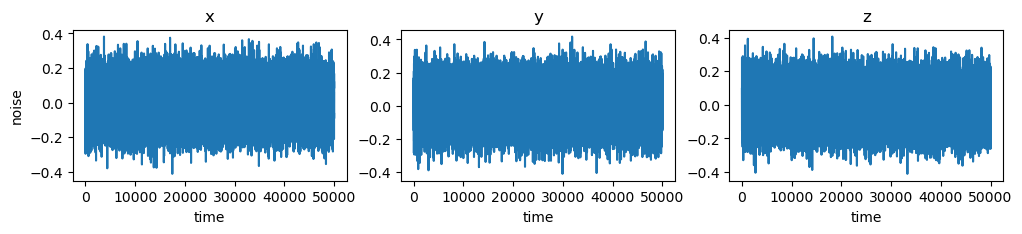

In [56]:
delta = y-x

#Stochastic sensor on the observer
rel_sense_mean = 0 #mean of relative measurement sensor
rel_sense_std = 0.1 #[0,0]-y[0,0]) * 0.3 #standard deviation of relative measurement scales with the distance
delta_noise = delta + np.random.normal(rel_sense_mean,rel_sense_std,size=delta.shape)

fig = plt.figure(figsize=(12, 2), dpi= 100, facecolor='w', edgecolor='k')
ax1 = plt.subplot(1,3,1)
ax1.plot(delta[:,0])
ax1.set_xlabel('time')
ax1.set_ylabel('delta')
ax1.set_title('dx')
ax2 = plt.subplot(1,3,2)
ax2.plot(delta[:,1])
ax2.set_xlabel('time')
ax2.set_title('dy')
ax3 = plt.subplot(1,3,3)
ax3.plot(delta[:,2])
ax3.set_xlabel('time')
ax3.set_title('dz')
plt.show()

#Noisy relaitve position data
fig = plt.figure(figsize=(12, 2), dpi= 100, facecolor='w', edgecolor='k')
ax1 = plt.subplot(1,3,1)
ax1.plot(delta_noise[:,0])
ax1.set_xlabel('time')
ax1.set_ylabel('noisy delta')
ax1.set_title('dx')
ax2 = plt.subplot(1,3,2)
ax2.plot(delta_noise[:,1]) 
ax2.set_xlabel('time')
ax2.set_title('dy')
ax3 = plt.subplot(1,3,3)
ax3.plot(delta_noise[:,2])
ax3.set_xlabel('time')
ax3.set_title('dz')
plt.show()

#value of the noise at each time step
fig = plt.figure(figsize=(12, 2), dpi= 100, facecolor='w', edgecolor='k')
ax1 = plt.subplot(1,3,1)
ax1.plot(delta_noise[:,0]-delta[:,0])
ax1.set_xlabel('time')
ax1.set_ylabel('noise')
ax1.set_title('x')
ax2 = plt.subplot(1,3,2)
ax2.plot(delta_noise[:,1]-delta[:,1])
ax2.set_xlabel('time')
ax2.set_title('y')
ax3 = plt.subplot(1,3,3)
ax3.plot(delta_noise[:,2]-delta[:,2])
ax3.set_xlabel('time')
ax3.set_title('z')
plt.show()


# DLL Iterative/Filtering Optimization loop
## Vectorized wise Cost Function

In [57]:
#DLL vector form cost function
x_up_std= 0.5
R = np.array([[x_up_std**2,0,0],[0,x_up_std**2,0],[0,0,x_up_std**2]])#np.ones((2,1)) #Observer process covariance matrix
Q = np.array([[rel_sense_std**2,0,0],[0,rel_sense_std**2,0],[0,0,rel_sense_std**2]])#np.ones((2,1)) #measurement covariance matrix
S = np.array([[x_up_std**2,0,0],[0,x_up_std**2,0],[0,0,x_up_std**2]])#np.ones((2,1)) #Feature process covariance matrix
P = np.array([[rel_sense_std**2,0,0],[0,x_up_std**2,0],[0,0,x_up_std**2]])#np.ones((2,1)) #Identification covariance matrix

R_inv = np.linalg.inv(R)
Q_inv = np.linalg.inv(Q)
S_inv = np.linalg.inv(S)
P_inv = np.linalg.inv(P)

def dll_opt(x):
    return ((np.array([x[0],x[1],x[2]]) - np.array(x_up)) @ R_inv @ (np.array([x[0],x[1],x[2]]) - np.array(x_up))
                + (np.array([x[3],x[4],x[5]]) - np.array(y_up)) @ S_inv @ (np.array([x[3],x[4],x[5]]) - np.array(y_up))
                + (delta_noise[i,:] - np.array([x[3]-x[0], x[4]-x[1], x[5]-x[2]])) @ Q_inv @ (delta_noise[i,:] - np.array([x[3]-x[0], x[4]-x[1], x[5]-x[2]])))

In [58]:
x_est = x0 #initialize observer estimate
y_est = y0 #initialize feature estimate

y_up = y_est #initial feature process update

X = np.array([x_est]) # x_est history 
Y = np.array([y_est]) # y_est history

x_dead_reck = x_est
X_dead_reck = np.array([x_dead_reck])



for i in range(int((tf/dt)-1)):#(45000)
   t_sim = i*dt
   
   x_proc_noise = np.random.normal(0,x_up_std,size=np.shape(x0))

   #Dead Reckoning baseline estimate
   x_dead_reck = odeint(lorenz, x_dead_reck, [t_sim,t_sim+dt], args = (sigma, rho, beta))[1,:] + x_proc_noise
   X_dead_reck = np.append(X_dead_reck, [x_dead_reck], axis=0)

   #calculate the Observer process update f(x_k-1) with noise
   x_up = odeint(lorenz, x_est, [t_sim,t_sim+dt], args = (sigma, rho, beta))[1,:]+ x_proc_noise

   #y_up = delta_noise[i,:] + x_up


   #minimize one time step (Filtering)
   opt_init = [x_up, y_up] #set optimization initial conditionsg!)
   state_est = sp.optimize.minimize(dll_opt, opt_init) #minimize position dimension
  

   #Save x_est
   x_est = np.array([state_est.x[0], state_est.x[1], state_est.x[2]]) # save x_est
   X = np.append(X, [x_est], axis=0) #update trajectory
   #Save y_est
   y_est = np.array([state_est.x[3], state_est.x[4], state_est.x[5]]) #save y_est
   Y = np.append(Y, [y_est], axis=0) #update trajecto

    #Dynamics Learningry

   if i > 990: #delay model learning for a number of time st eps
      if i%1000 == 0:
         #(SINDY)
         model.fit(Y,t = dt)   
         model.print()
         #calculate the feature process update based on most recent dynamics estimate g(y_k-1)
         y_up = model.simulate(y_est,[t_sim,t_sim+dt])[1,:]
      else:
         y_up = model.simulate(y_est,[t_sim,t_sim+dt])[1,:]
   else:
         y_up = delta_noise[i,:] + x_up        
         #y_up = model.simulate(y_est,[t_sim,t_sim+dt])[1,:]


x' = 4.078 1 + -5.434 x + 5.599 y + -0.220 z + 0.077 x^2 + -0.119 x y + -0.043 x z + 0.045 y^2 + 0.035 y z
y' = 56.814 1 + -0.973 x + 3.245 y + -3.951 z + -0.025 x y + -0.228 x z + -0.016 y^2 + 0.073 y z + 0.073 z^2
z' = -95.342 1 + -2.072 x + 1.559 y + 3.731 z + -0.606 x^2 + 1.312 x y + 0.037 x z + -0.473 y^2 + -0.018 y z + -0.018 z^2
x' = 0.937 1 + -7.215 x + 7.104 y + -0.064 z + 0.038 x^2 + -0.057 x y + -0.023 x z + 0.022 y^2 + 0.025 y z
y' = 22.892 1 + -0.173 x + 2.620 y + -0.725 z + 0.051 x y + -0.346 x z + -0.063 y^2 + 0.117 y z
z' = -46.850 1 + 0.793 x + -0.271 y + 1.460 z + -0.457 x^2 + 1.112 x y + -0.031 x z + -0.388 y^2
x' = 0.015 1 + -7.630 x + 7.424 y + -0.012 z + 0.031 x^2 + -0.049 x y + -0.019 x z + 0.018 y^2 + 0.024 y z
y' = 14.789 1 + -0.712 x + 2.948 y + -0.541 z + -0.019 x^2 + 0.078 x y + -0.346 x z + -0.063 y^2 + 0.121 y z
z' = -34.230 1 + 0.908 x + -0.174 y + 1.043 z + -0.415 x^2 + 1.032 x y + -0.022 x z + -0.371 y^2 + -0.020 y z
x' = 0.370 1 + -7.785 x + 7.603 y + 

In [59]:
#Baseline feature dead reckoning estimate
Y_dead_reck = delta_noise[0:X_dead_reck.shape[0],:]+X_dead_reck 
#Y_dead_reck = delta[0:X_dead_reck.shape[0],:]+X_dead_reck 

### Plot estimated trajectories & Error


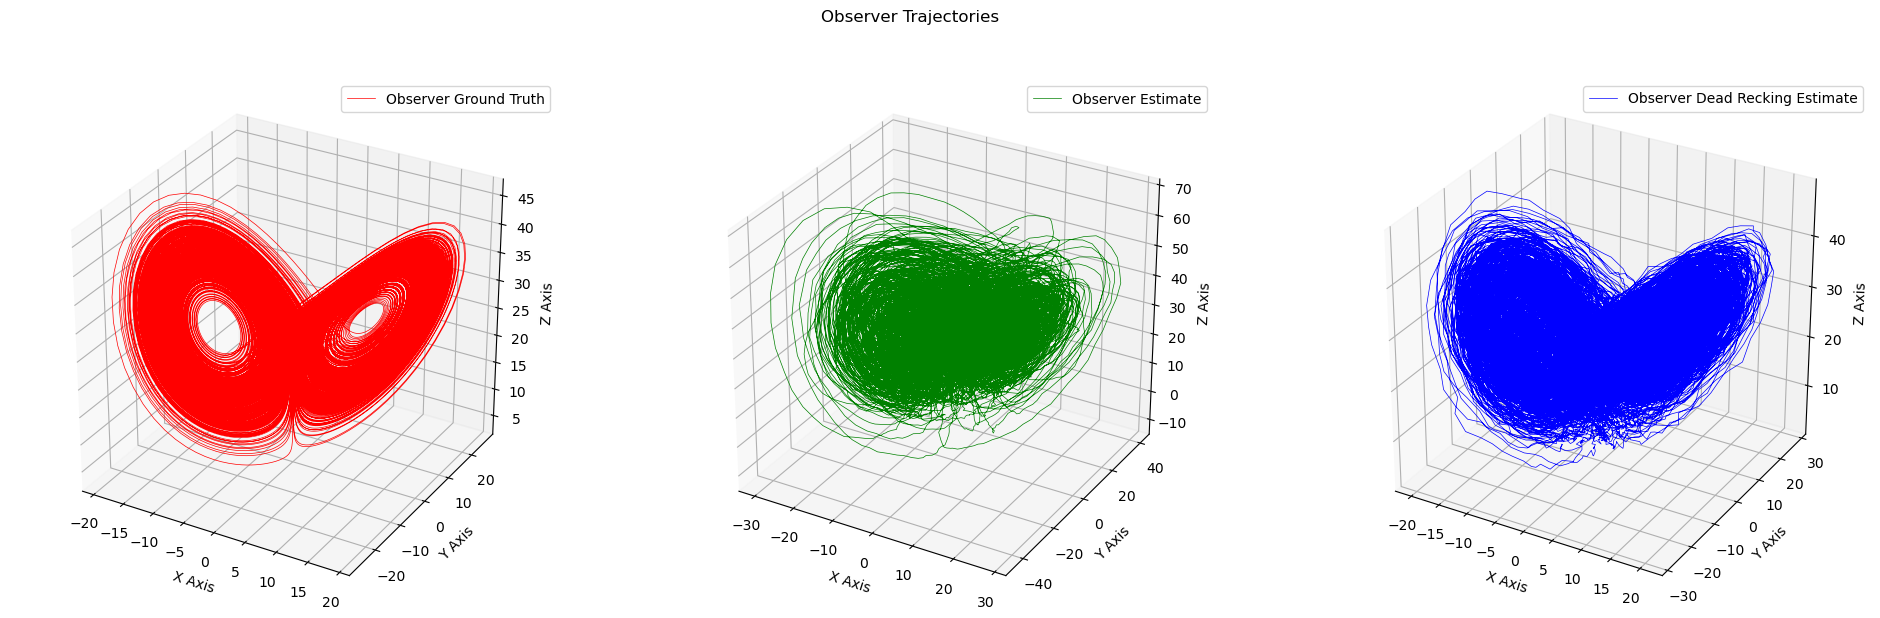

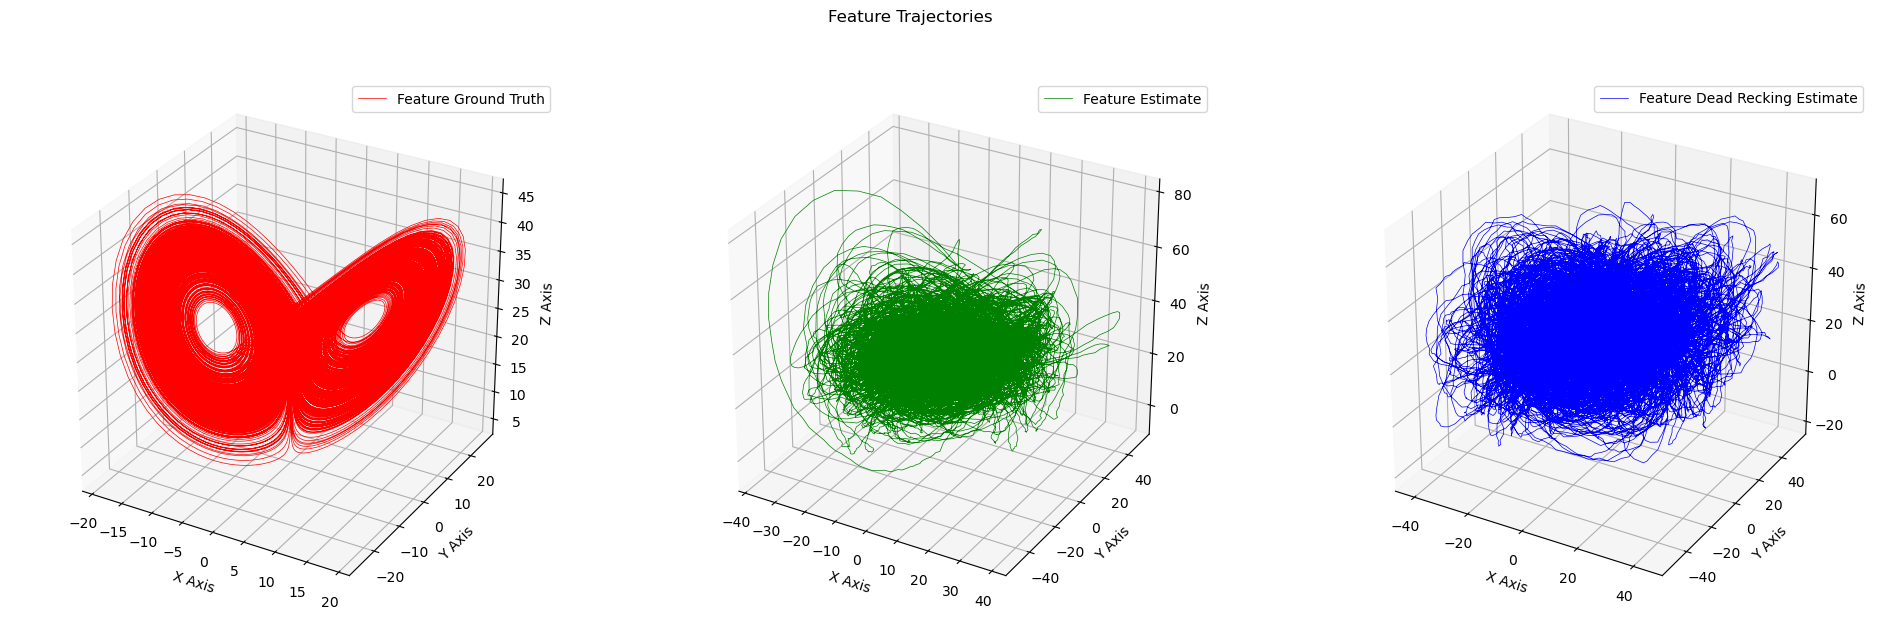

In [60]:
# Plot Observer trajectories
fig = plt.figure(figsize=(24, 7), dpi= 100, facecolor='w', edgecolor='k')
fig.suptitle('Observer Trajectories', fontsize=12)

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot(x[:,0], x[:,1], x[:,2], lw=0.5, label='Observer Ground Truth', color='r')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
#ax.set_title("Lorenz Attractor")
ax.legend()

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2], lw=0.5, label='Observer Estimate', color='g')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
#ax.set_title("Lorenz Attractor")
ax.legend()

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot(X_dead_reck[:,0], X_dead_reck[:,1], X_dead_reck[:,2], lw=0.5, label='Observer Dead Recking Estimate', color='b')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
#ax.set_title("Lorenz Attractor")
ax.legend()

plt.show()

# Plot Feature trajectories
fig = plt.figure(figsize=(24, 7), dpi= 100, facecolor='w', edgecolor='k')
fig.suptitle('Feature Trajectories', fontsize=12)

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot(y[:,0], y[:,1], y[:,2], lw=0.5, label='Feature Ground Truth', color='r')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.legend()

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot(Y[:,0], Y[:,1], Y[:,2], lw=0.5, label='Feature Estimate', color='g')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.legend()

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot(Y_dead_reck[:,0], Y_dead_reck[:,1], Y_dead_reck[:,2], lw=0.5, label='Feature Dead Recking Estimate', color='b')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.legend()

plt.show()

In [61]:
# Plot observer on top of each other
# fig = plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
# ax = fig.gca(projection='3d')
# ax.plot(x[:,0], x[:,1], x[:,2], lw=0.5, label='Observer Ground Truth')
# ax.plot(X[:,0], X[:,1], X[:,2], lw=0.5, label='Observer Estimate')
# ax.plot(X_dead_reck[:,0], X_dead_reck[:,1], X_dead_reck[:,2], lw=0.5, label='Observer Dead Recking Estimate')
# ax.set_xlabel("X Axis")
# ax.set_ylabel("Y Axis")
# ax.set_zlabel("Z Axis")
# ax.set_title("Lorenz Attractor")
# ax.legend()
# plt.show()


#plot feature trajectories on top of each other
# fig = plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
# ax = fig.gca(projection='3d')
# ax.plot(y[:,0], y[:,1], y[:,2], lw=0.5, label='Feature Ground Truth')
# ax.plot(Y[:,0], Y[:,1], Y[:,2], lw=0.5, label='Feature Estimate')
# ax.plot(Y_dead_reck[:,0], Y_dead_reck[:,1], Y_dead_reck[:,2], lw=0.5, label='Feature Dead Recking Estimate')
# ax.set_xlabel("X Axis")
# ax.set_ylabel("Y Axis")
# ax.set_zlabel("Z Axis")
# ax.set_title("Lorenz Attractor")
# ax.legend()
# plt.show()

<ipython-input-62-e22f87d55914>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
<ipython-input-62-e22f87d55914>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
<ipython-input-62-e22f87d55914>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()
<ipython-input-62-e22f87d55914>:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig4.show()


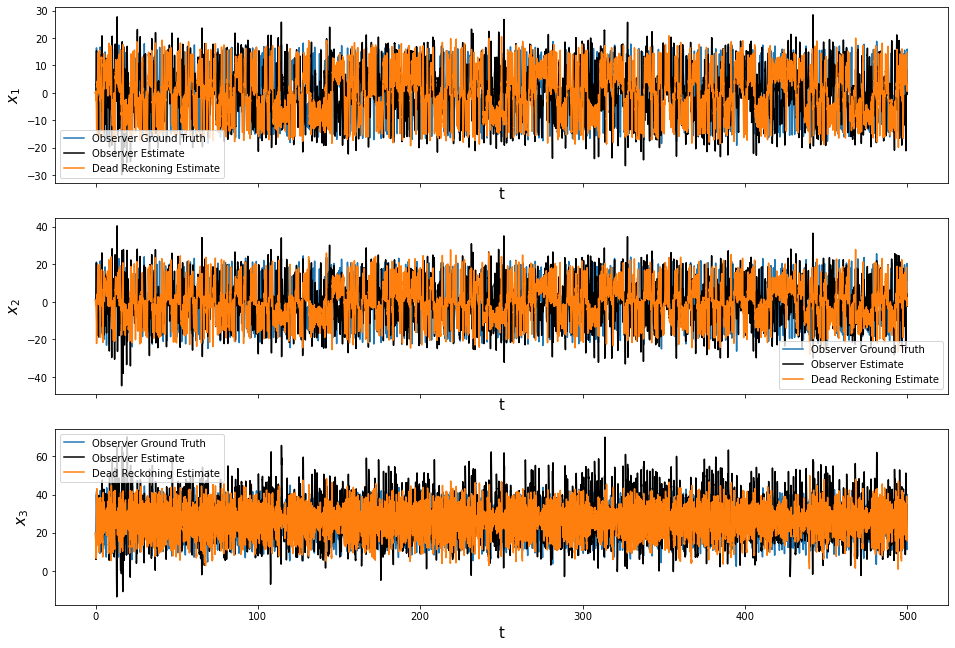

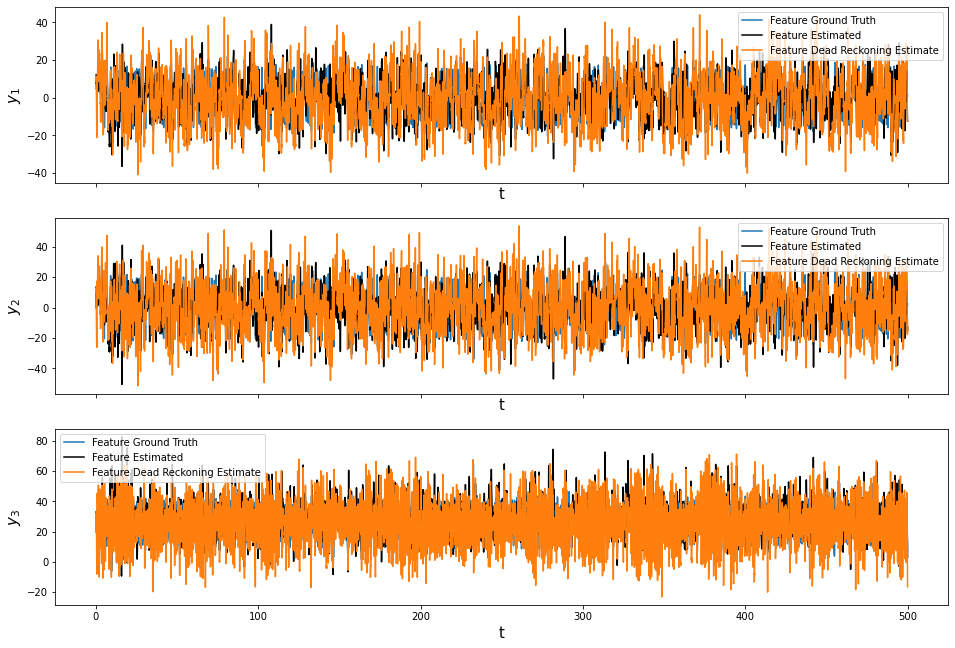

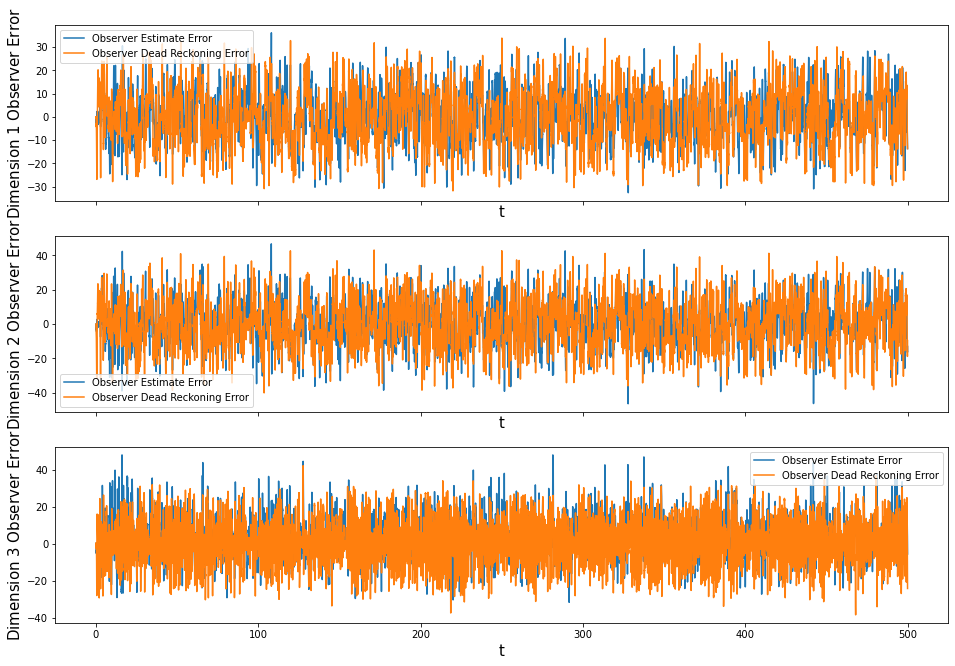

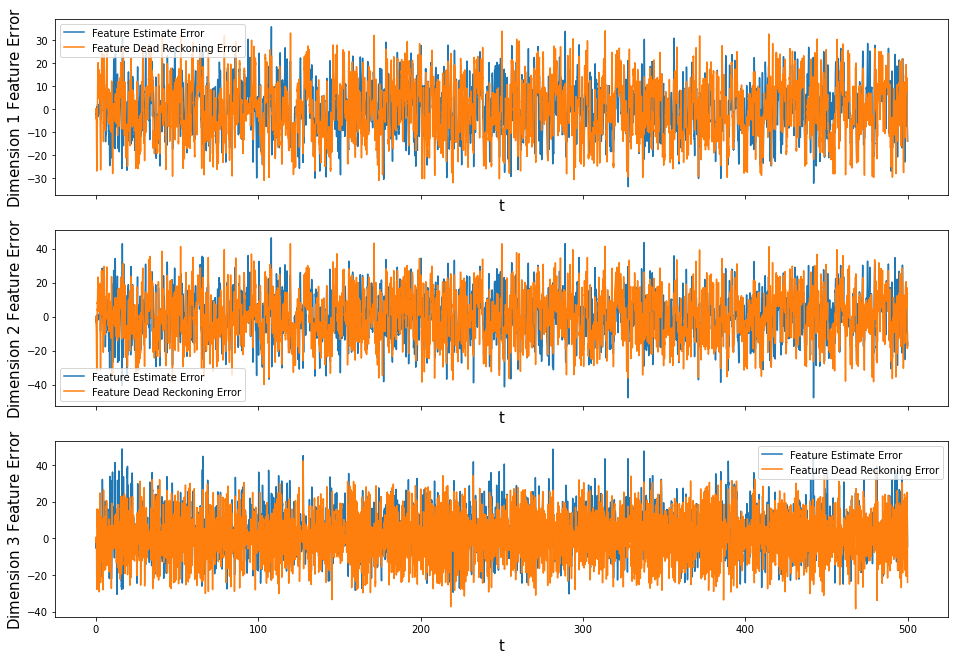

In [62]:
fig1, axs = plt.subplots(X.shape[1], 1, sharex=True, figsize=(16, 11))
for i in range(X.shape[1]):
    axs[i].plot(t[0:X.shape[0]], x[0:X.shape[0], i] , label='Observer Ground Truth')
    axs[i].plot(t[0:X.shape[0]], X[:, i], 'k', label='Observer Estimate')
    axs[i].plot(t[0:X.shape[0]], X_dead_reck[0:X.shape[0], i], label='Dead Reckoning Estimate')
    axs[i].legend()
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$x_{}$'.format(i+1), fontsize = 15)
fig1.show()

fig2, axs = plt.subplots(Y.shape[1], 1, sharex=True, figsize=(16, 11))
for i in range(Y.shape[1]):
    axs[i].plot(t[0:Y.shape[0]], y[0:Y.shape[0], i], label='Feature Ground Truth')
    axs[i].plot(t[0:Y.shape[0]], Y[:, i], 'k', label='Feature Estimated')
    axs[i].plot(t[0:Y.shape[0]], Y_dead_reck[0:Y.shape[0], i], label='Feature Dead Reckoning Estimate')
    axs[i].legend()
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$y_{}$'.format(i+1), fontsize = 15)
fig2.show()

fig3, axs = plt.subplots(Y.shape[1], 1, sharex=True, figsize=(16, 11))
for i in range(Y.shape[1]):
    axs[i].plot(t[0:X.shape[0]], X[:, i] - x[0:X.shape[0], i], label='Observer Estimate Error')
    axs[i].plot(t[0:X.shape[0]], X_dead_reck[0:X.shape[0], i] - x[0:X.shape[0], i], label='Observer Dead Reckoning Error')
    axs[i].legend()
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('Dimension ${}$ Observer Error'.format(i+1), fontsize = 15)
fig3.show()

fig4, axs = plt.subplots(Y.shape[1], 1, sharex=True, figsize=(16, 11))
for i in range(Y.shape[1]):
  
    axs[i].plot(t[0:X.shape[0]], Y[:, i] - y[0:X.shape[0], i], label='Feature Estimate Error')
    axs[i].plot(t[0:Y.shape[0]], Y_dead_reck[:, i] - y[0:X.shape[0], i], label='Feature Dead Reckoning Error')
    axs[i].legend()
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('Dimension ${}$ Feature Error'.format(i+1), fontsize = 15)
fig4.show()

### Cumulative error

In [63]:
X_cum = np.array([[0,0,0]])
X_cum_dead = np.array([[0,0,0]])
Y_cum = np.array([[0,0,0]])
Y_cum_dead = np.array([[0,0,0]])

for j in range(1,X.shape[0]):
    x_cum = np.sum(np.abs((X - x[0:X.shape[0], :])[0:j,:]) , axis=0)
    X_cum = np.append(X_cum, [x_cum], axis=0)

    x_cum_dead = np.sum(np.abs((X_dead_reck - x[0:X.shape[0], :])[0:j,:]) , axis=0)
    X_cum_dead = np.append(X_cum_dead, [x_cum_dead], axis=0)

    y_cum = np.sum(np.abs((Y - y[0:X.shape[0], :])[0:j,:]) , axis=0)
    Y_cum = np.append(Y_cum, [y_cum], axis=0)

    y_cum_dead = np.sum(np.abs((Y_dead_reck - y[0:X.shape[0], :])[0:j,:]) , axis=0)
    Y_cum_dead = np.append(Y_cum_dead, [y_cum_dead], axis=0)



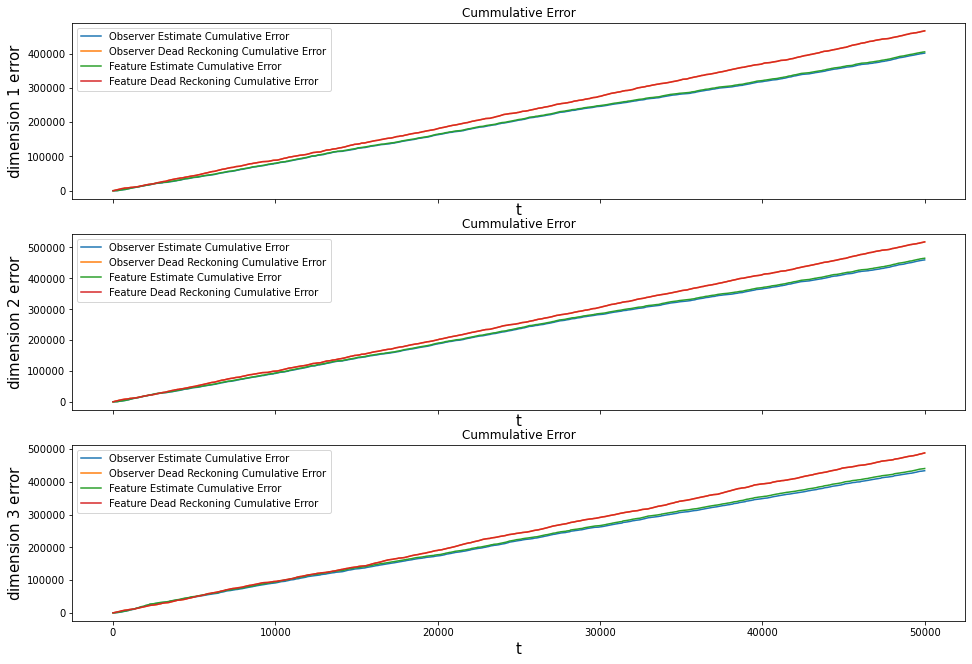

In [64]:
fig1, axs = plt.subplots(X.shape[1], 1, sharex=True, figsize=(16, 11))
#fig.suptitle('Cummulative Error', fontsize=12)
for i in range(X.shape[1]):
    axs[i].plot(np.arange(0,j+1), X_cum[:,i], label = 'Observer Estimate Cumulative Error')
    axs[i].plot(np.arange(0,j+1), X_cum_dead[:,i], label = 'Observer Dead Reckoning Cumulative Error')
    axs[i].plot(np.arange(0,j+1), Y_cum[:,i], label = 'Feature Estimate Cumulative Error')
    axs[i].plot(np.arange(0,j+1), Y_cum_dead[:,i], label = 'Feature Dead Reckoning Cumulative Error')
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('dimension ${}$ error'.format(i+1), fontsize = 15)
    axs[i].set_title('Cummulative Error')
    axs[i].legend()

### Average Error

In [65]:
x_err_avg = x_cum/(j+1)
x_dead_err_avg= x_cum_dead/(j+1)
y_err_avg = y_cum/(j+1)
y_dead_err_avg= y_cum_dead/(j+1)

print('The observer DLL estimate average error is', x_err_avg, 'units.')
print('The observer Dead Reckoning estimate average error is', x_dead_err_avg, 'units.')
print('The feature DLL estimate average error is', y_err_avg, 'units.')
print('The Feature Dead Reckoning estimate average error is', y_dead_err_avg, 'units.')

The observer DLL estimate average error is [8.02048208 9.19537448 8.68150463] units.
The observer Dead Reckoning estimate average error is [ 9.32121997 10.3626359   9.76763483] units.
The feature DLL estimate average error is [8.09734314 9.30324272 8.81646102] units.
The Feature Dead Reckoning estimate average error is [ 9.32231553 10.36269665  9.76793365] units.


### Learned Feature Dynamics

x' = 0.360 1 + -9.271 x + 9.260 y
y' = -0.953 1 + -5.569 x + 5.701 y + -0.025 x^2 + 0.060 x y + -0.243 x z + -0.022 y^2 + 0.101 y z
z' = -11.286 1 + 0.588 x + -0.376 y + 0.610 z + -0.411 x^2 + 0.878 x y + -0.359 y^2


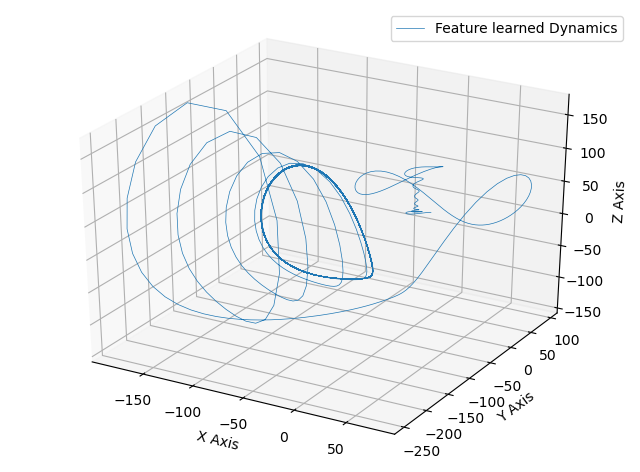

In [66]:
model.fit(Y,t = dt)   
model.print()
Y_learned = model.simulate(y0, t)

# Plot Learned Dyanamical system
fig = plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')

ax.plot(Y_learned[:,0], Y_learned[:,1], Y_learned[:,2], lw=0.5, label='Feature learned Dynamics')

ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.legend()

plt.show()

## NOTES


In [67]:
# model = ps.SINDy(
#     differentiation_method=differentiation_method,
#     feature_library=poly_library,
#     optimizer=Lasso(alpha=2000, max_iter=2000, fit_intercept=False), feature_names=["x", "y", "z"])
# model.fit(X,t=dt)
# model.print() 

In [68]:
#define cost function
# def x_opt(x): #first dimension cost function
#     return (x[0] - x_up[0]) ** 2 * R_inv + (x[3] - y_up[0]) ** 2 * S_inv + (delta_noise[i,0] - (x[3]-x[0])) ** 2 * Q_inv

# def y_opt(x): #second dimension cost function   
#     return (x[1] - x_up[1]) ** 2 * R_inv + (x[4] - y_up[1]) ** 2 * S_inv + (delta_noise[i,1] - (x[4]-x[1])) ** 2 * Q_inv

# def z_opt(x): #third dimension cost function   
#     return (x[2] - x_up[2]) ** 2 * R_inv + (x[5] - y_up[2]) ** 2 * S_inv + (delta_noise[i,2] - (x[5]-x[2])) ** 2 * Q_inv

    #Full cost function in vector form.         
    #(np.array([x[0],x[1]]) - np.array(x_up)) ** 2 * R_inv + (np.array([x[2],x[3]]) - np.array(y_up)) ** 2 * S_inv + (delta_noise - np.array([x[2]-x[0],x[3]-x[1]]))        ** 2 * Q_inv}

In [69]:
n = np.array([1,2,3])
E = np.array([[1,0,0],[0,2,0],[0,0,3]])

((-n)**2) * E
 
np.dot(((-n)**2),E)
np.matmul(((-n)**2),E)



array([ 1,  8, 27])

In [70]:
v = [1,1,1,1,1,1]

#((np.array([v[0],v[1],v[2]]) - np.array(x_up)) @ R_inv @ (np.array([v[0],v[1],v[2]]) - np.array(x_up))
#+(np.array([v[3],v[4],v[5]]) - np.array(y_up)) @ S_inv @ (np.array([v[3],v[4],v[5]]) - np.array(y_up))
#+(delta_noise[i,:] - np.array([v[3]-v[0], v[4]-v[1], v[5]-v[2]])) @ Q_inv @ (delta_noise[i,:] - np.array([v[3]-v[0], v[4]-v[1], v[5]-v[2]])))

In [71]:
x= [1,1,1,1,1,1]
((np.array([x[0],x[1],x[2]]) - np.array(x_up)) @ R_inv @ (np.array([x[0],x[1],x[2]]) - np.array(x_up))
                + (np.array([x[3],x[4],x[5]]) - np.array(y_up)) @ S_inv @ (np.array([x[3],x[4],x[5]]) - np.array(y_up))
                + (delta_noise[i,:] - np.array([x[3]-x[0], x[4]-x[1], x[5]-v[2]])) @ Q_inv @ (delta_noise[i,:] - np.array([x[3]-v[0], x[4]-x[1], x[5]-x[2]])))([x[0],x[1],x[2]]) - np.array(x_up)) @ R_inv @ (np.array([x[0],x[1],x[2]]) - np.array(x_up))
                + (np.array([x[3],x[4],x[5]]) - np.array(y_up)) @ S_inv @ (np.array([x[3],x[4],x[5]]) - np.array(y_up))
                + (delta_noise[i,:] - np.array([x[3]-x[0], x[4]-x[1], x[5]-v[2]])) @ Q_inv @ (delta_noise[i,:] - np.array([x[3]-v[0], x[4]-x[1], x[5]-x[2]])))

SyntaxError: unmatched ')' (<ipython-input-71-f032e9bfe919>, line 4)

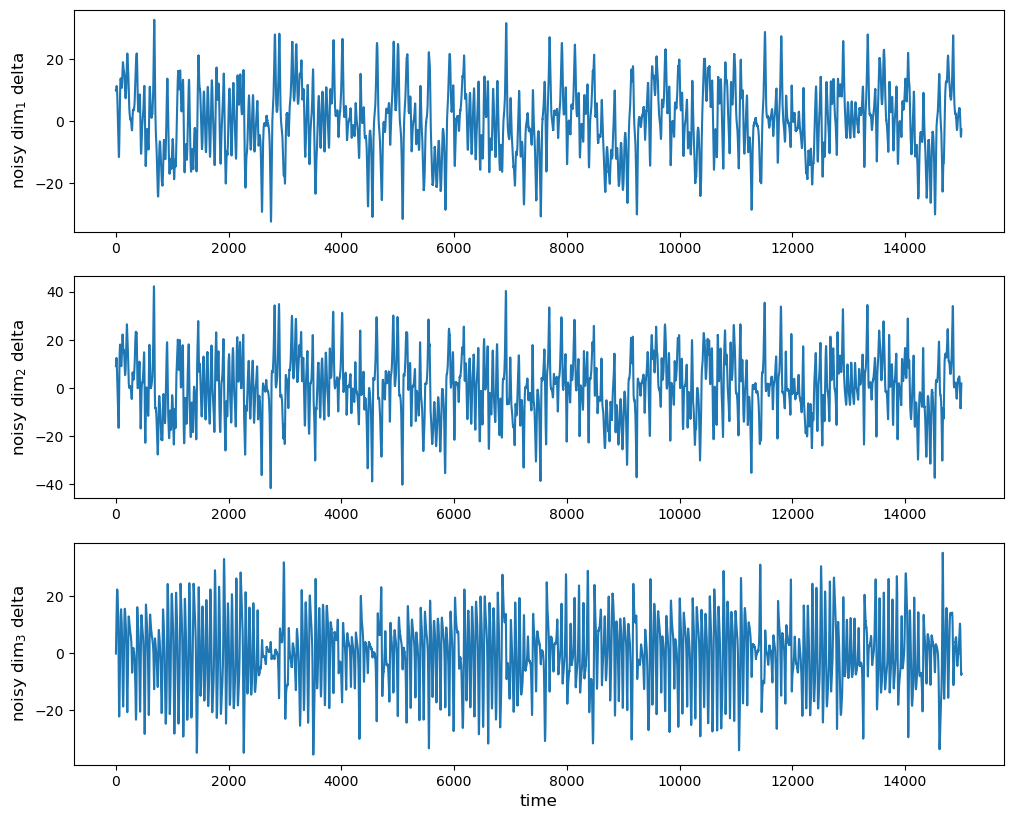

In [ ]:
#Noisy relaitve position data
fig = plt.figure(figsize=(12, 10), dpi= 100, facecolor='w', edgecolor='k')
ax1 = plt.subplot(3,1,1)
ax1.plot(delta_noise[:,0])
# ax1.set_xlabel('time',fontsize = 15)
ax1.set_ylabel('noisy dim$_1$ delta',fontsize = 12)
#ax1.set_title('dx')
ax2 = plt.subplot(3,1,2)
ax2.plot(delta_noise[:,1])
# ax2.set_xlabel('time')
ax2.set_ylabel('noisy dim$_2$ delta',fontsize = 12)
##ax2.set_title('dy')
ax3 = plt.subplot(3,1,3)
ax3.plot(delta_noise[:,2])
ax3.set_xlabel('time',fontsize = 12)
ax3.set_ylabel('noisy dim$_3$ delta',fontsize = 12)
#a#x3.set_title('dz')
plt.show()


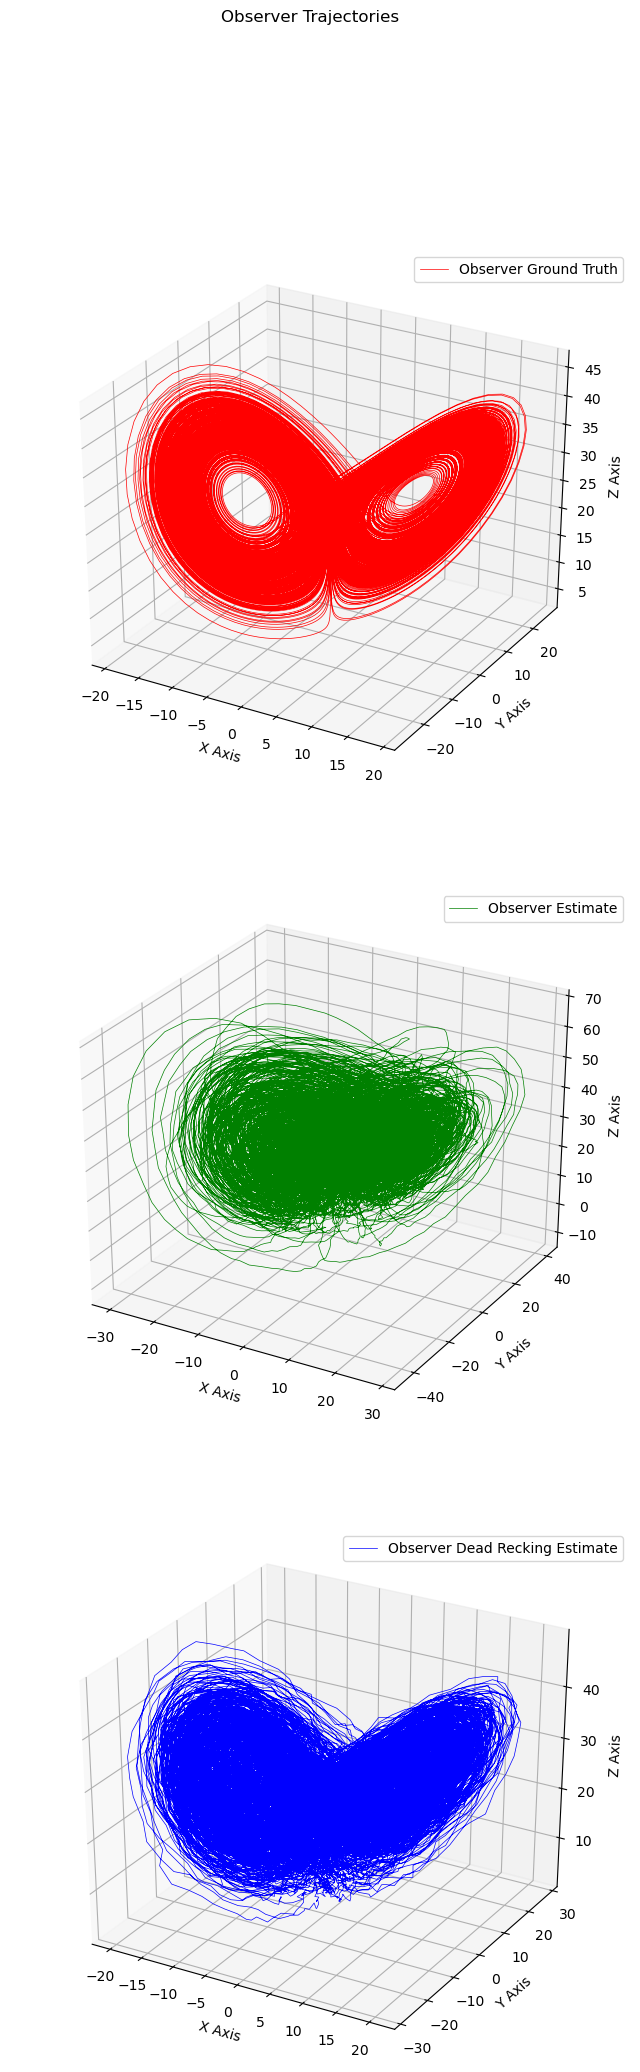

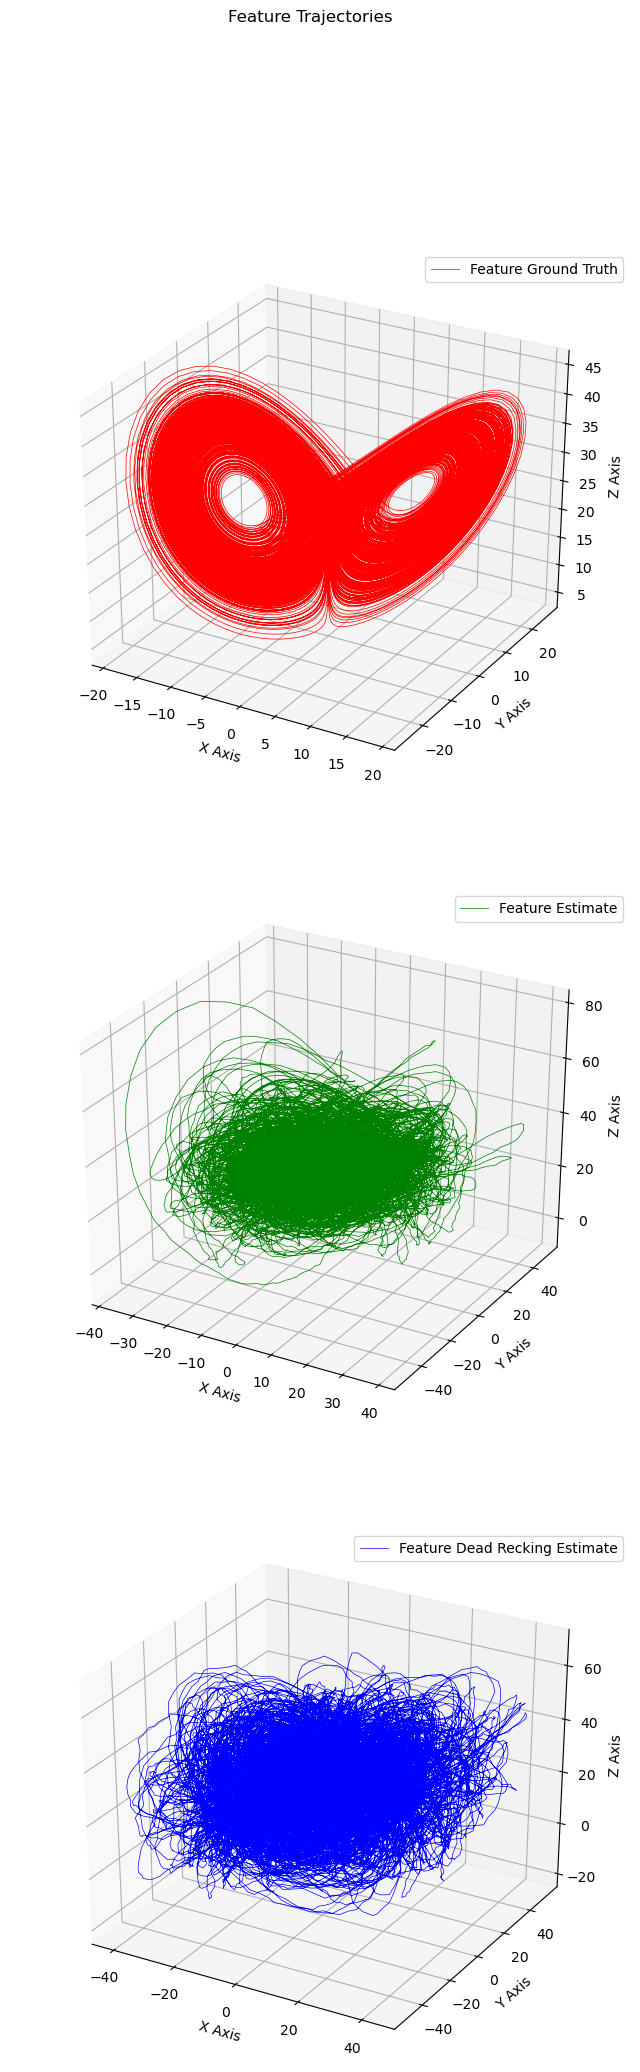

In [73]:
# Plot Observer trajectories
fig = plt.figure(figsize=(8, 24), dpi= 100, facecolor='w', edgecolor='k')
fig.suptitle('Observer Trajectories', fontsize=12)

ax = fig.add_subplot(3, 1, 1, projection='3d')
ax.plot(x[:,0], x[:,1], x[:,2], lw=0.5, label='Observer Ground Truth', color='r')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
#ax.set_title("Lorenz Attractor")
ax.legend()

ax = fig.add_subplot(3, 1, 2, projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2], lw=0.5, label='Observer Estimate', color='g')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
#ax.set_title("Lorenz Attractor")
ax.legend()

ax = fig.add_subplot(3, 1, 3, projection='3d')
ax.plot(X_dead_reck[:,0], X_dead_reck[:,1], X_dead_reck[:,2], lw=0.5, label='Observer Dead Recking Estimate', color='b')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
#ax.set_title("Lorenz Attractor")
ax.legend()

plt.show()

# Plot Feature trajectories
fig = plt.figure(figsize=(8, 24), dpi= 100, facecolor='w', edgecolor='k')
fig.suptitle('Feature Trajectories', fontsize=12)

ax = fig.add_subplot(3, 1, 1, projection='3d')
ax.plot(y[:,0], y[:,1], y[:,2], lw=0.5, label='Feature Ground Truth', color='r')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.legend()

ax = fig.add_subplot(3, 1, 2, projection='3d')
ax.plot(Y[:,0], Y[:,1], Y[:,2], lw=0.5, label='Feature Estimate', color='g')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.legend()

ax = fig.add_subplot(3, 1, 3, projection='3d') 
ax.plot(Y_dead_reck[:,0], Y_dead_reck[:,1], Y_dead_reck[:,2], lw=0.5, label='Feature Dead Recking Estimate', color='b')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.legend()

plt.show()

In [ ]:
5**2

25